# MovieLens 1m Collaborative Genre Tagging
**To do**:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens1m.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

## Load rating data

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
path = 'data/ml-1m/'  # if the files are local
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [4]:
df.shape

(1000209, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 6040
Number of items: 3706
Min item rating: 1
Max item rating: 5
Mean item rating: 3.581564453029317


## Load movie metadata
  - remove 10% as holdout test set

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,James and the Giant Peach (1996),0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,My Fair Lady (1964),0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,3,Erin Brockovich (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,"Bug's Life, A (1998)",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
movies, movies_holdout = train_test_split(movies, test_size=.1, random_state=42)

---
# Create baseline features
For each user, calculate average user bias - the average difference between the user's rating and the movie's average rating:

$$b_{u} = \dfrac{\sum_{j=1}^{n_u} (r_{uj} - \mu_i)}{n_u}$$

For each item, calculate the difference between its average rating and the average rating of all movies:

$$b_{i} = \dfrac{\sum_{k=1}^{n_i} (r_{ki})}{n_i} - \mu$$

Then, for each interaction, calculate the combined bias:

$$b_{ui} = \dfrac{b_u + b_i}{2}$$

In [9]:
from CGT import get_baseline
?get_baseline

Signature: get_baseline(df, train_index, test_index, user_col, item_col)
Docstring:
Calculate baseline features from an explicit ratings dataset. Receives a dataframe
and returns train and test splits with added bias column and mean rating value.
User and item biases are calculated as average difference from global mean rating.
Baseline factors are only calculated from training observations, with users or
items that do not appear in train receiving the global average as default.

Args:
    df          : explicit ratings dataframe with columns userId, movieId and rating
    train_index : train index splits taken from KFold.splits()
    test_index  : test index splits taken from KFold.splits()
    
Returns:
    train, test : train/test splits of df, with added bias column
    global_mean : average rating of all training observations
File:      d:\myfiles\deep-collaborative-filtering\cgt.py
Type:      function


---
# CGT model
**To do**:
  - Can we avoid re-training rating model on CV fold?
  - Create a grid search function / class

In [10]:
from CGT import compile_genre_model
?compile_genre_model

Signature:
compile_genre_model(
    n_items,
    n_users,
    min_rating,
    max_rating,
    mean_rating,
    n_latent=1000,
    n_hidden_1=None,
    n_hidden_2=200,
    activation='relu',
    dropout_1=0.2,
    dropout_2=0.2,
    random_seed=42,
)
Docstring: <no docstring>
File:      d:\myfiles\deep-collaborative-filtering\cgt.py
Type:      function


---
## Grid search
**To do**: try using [tqdm](https://github.com/tqdm/tqdm) notebook bars

```bash
# bash
pip install --upgrade ipywidgets 
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

```python
# python
from tqdm.notebook import trange, tqdm
from time import sleep

for i in trange(3, desc='1st loop'):
    for j in tqdm(range(100), desc='2nd loop'):
        sleep(0.01)
```

## 1. Number of latent factors and hidden nodes

In [11]:
from sklearn.model_selection import KFold

In [12]:
bs1 = 2048
bs2 = 128

In [13]:
# hyper parameters
HP_N_FACTORS = [200, 1000]
HP_N_HIDDEN_2 = [[100], [200], [500]]

In [14]:
# dataframe to store results of grid search
grid_results = []
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN_2)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN_2 in HP_N_HIDDEN_2:

        print(f'Fitting CGT model #{searches} with {N_FACTORS} | {N_HIDDEN_2} architecture')
        searches += 1

        # Create 5 CV folds
        kf = KFold(n_splits=5, random_state=42)

        # initialise loss and epoch count
        total_loss = 0
        total_acc = 0
        count = 1

        # do CV split and compute baseline predictors each time
        for train_index, test_index in kf.split(movies):

            # get baseline rating predictors for full dataset
            train, _, _ = get_baseline(df, df.index, df.index, 'userId', 'movieId')

            # compile both models with search hparams
            model1, model2 = compile_genre_model(
                n_items=df.movieId.nunique(),
                n_users=df.userId.nunique(),
                min_rating=df.rating.min(),
                max_rating=df.rating.max(),
                mean_rating=df.rating.mean(),
                n_latent=N_FACTORS,
                n_hidden_2=N_HIDDEN_2
            )

            # train rating model on all data
            ratings = model1.fit(
                x=[train.userId.values, train.movieId.values, train.bias.values],
                y=train.rating.values, 
                batch_size=bs1,
                epochs=4,
                verbose=0,
                validation_split=.2
            )

            # train genre model on 5 CV folds
            train = movies.iloc[train_index]
            test = movies.iloc[test_index]

            # train model on current fold
            result = model2.fit(
                train.movieId.values, train.Drama.values,
                batch_size=bs2, 
                epochs=4,
                verbose=0,
                validation_data=(test.movieId.values, test.Drama.values))

            # get loss from this fold
            fold_loss = result.history['val_loss'][-1]
            total_loss += fold_loss
            fold_acc = result.history['val_accuracy'][-1]
            total_acc += fold_acc

            count += 1

            del model1, model2

        # calculate average holdout loss across all CV folds
        avg_loss = total_loss / 5
        avg_acc = total_acc / 5
        print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
        print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

        grid_results.append({'n_factors':N_FACTORS,
                             'n_hidden_2':N_HIDDEN_2,
                             'val_loss':avg_loss,
                             'val_acc':avg_acc,
                             'train_loss_hist':result.history['loss'],
                             'val_loss_hist':result.history['val_loss'],
                             'train_acc_hist':result.history['accuracy'],
                             'val_acc_hist':result.history['val_accuracy']})

        print()
#             break
#         break
#     break
    
col_order = grid_results[0].keys()

# save results to data frame
grid_results = pd.DataFrame(grid_results)
# reorder columns
grid_results = grid_results[col_order]

Fitting total of 6 models

Fitting CGT model #1 with 200 | [100] architecture
_____________________________________CV avg val loss=0.5475
_____________________________________CV avg val acc=0.7136

Fitting CGT model #2 with 200 | [200] architecture
_____________________________________CV avg val loss=0.5343
_____________________________________CV avg val acc=0.7205

Fitting CGT model #3 with 200 | [500] architecture
_____________________________________CV avg val loss=0.5265
_____________________________________CV avg val acc=0.7262

Fitting CGT model #4 with 1000 | [100] architecture
_____________________________________CV avg val loss=0.5146
_____________________________________CV avg val acc=0.7268

Fitting CGT model #5 with 1000 | [200] architecture
_____________________________________CV avg val loss=0.5099
_____________________________________CV avg val acc=0.7316

Fitting CGT model #6 with 1000 | [500] architecture
_____________________________________CV avg val loss=0.5123
____

In [15]:
# get best 5 models
grid_results = grid_results.sort_values('val_loss')
grid_results.to_csv(path+'grid_results.csv', index=False)

grid_results.head(5)

,n_factors,n_hidden_2,val_loss,val_acc,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
4,1000,[200],0.509857,0.731634,"[0.6218403486655034, 0.5262336130442469, 0.462...","[0.574642991108158, 0.5394106252618815, 0.5232...","[0.65029985, 0.73688155, 0.7841079, 0.8152174]","[0.68815595, 0.7076462, 0.7076462, 0.7031484]"
5,1000,[500],0.512283,0.729835,"[0.6038676459213783, 0.48446702152892746, 0.41...","[0.5579619652506472, 0.5264286188439451, 0.522...","[0.66229385, 0.7642429, 0.8167167, 0.84745127]","[0.6896552, 0.71064466, 0.7091454, 0.71214396]"
3,1000,[100],0.514632,0.726837,"[0.6372405948310063, 0.5540730844194564, 0.497...","[0.5902588390696353, 0.5548348635926597, 0.533...","[0.64767617, 0.72488755, 0.75524735, 0.78710645]","[0.6551724, 0.69865066, 0.71214396, 0.70614696]"
2,200,[500],0.526505,0.726237,"[0.620500065218741, 0.5490421091598728, 0.5114...","[0.5759823184678222, 0.551262981396565, 0.5396...","[0.64430285, 0.71851575, 0.7436282, 0.755997]","[0.67016494, 0.6971514, 0.69865066, 0.70614696]"
1,200,[200],0.534293,0.720540,"[0.6375066141138549, 0.5780768434683243, 0.539...","[0.5938232333763785, 0.5667982614826763, 0.550...","[0.6394303, 0.69003, 0.7241379, 0.73913044]","[0.6611694, 0.69265366, 0.70464766, 0.7031484]"


In [16]:
best_hparams = grid_results.iloc[0,:][['n_factors', 'n_hidden_2']]
best_hparams

n_factors      1000
n_hidden_2    [200]
Name: 4, dtype: object

## 2. Number of epochs

In [20]:
epoch_1 = 4
best_hparams = pd.concat((best_hparams, pd.Series({'epoch_1': epoch_1})))
best_hparams

n_factors      1000
n_hidden_2    [200]
epoch_1           4
dtype: object

In [21]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (16,9),
            'font.family': 'serif'})

In [23]:
del model1, model2

# compile both models
model1, model2 = compile_genre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_latent=best_hparams.n_factors,
    n_hidden_2=best_hparams.n_hidden_2
)

# train rating model
training = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=bs1,
    epochs=best_hparams.epoch_1,
    verbose=1,
    validation_split=.2
)

Train on 800167 samples, validate on 200042 samples
Epoch 1/4
800167/800167 [==============================] - 63s 79us/sample - loss: 0.8893 - val_loss: 0.9348
Epoch 2/4
800167/800167 [==============================] - 61s 76us/sample - loss: 0.5997 - val_loss: 0.9373
Epoch 3/4
800167/800167 [==============================] - 58s 73us/sample - loss: 0.3126 - val_loss: 0.9401
Epoch 4/4
800167/800167 [==============================] - 58s 73us/sample - loss: 0.1270 - val_loss: 0.9423


In [24]:
# train genre model
training = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=bs2, 
    epochs=10,
    validation_split=.2)

Train on 2668 samples, validate on 667 samples
Epoch 1/10
2668/2668 [==============================] - 1s 387us/sample - loss: 0.6218 - accuracy: 0.6503 - AUC: 0.7152 - val_loss: 0.5746 - val_accuracy: 0.6882 - val_AUC: 0.7270
Epoch 2/10
2668/2668 [==============================] - 0s 150us/sample - loss: 0.5262 - accuracy: 0.7369 - AUC: 0.8209 - val_loss: 0.5394 - val_accuracy: 0.7076 - val_AUC: 0.7724
Epoch 3/10
2668/2668 [==============================] - 0s 147us/sample - loss: 0.4630 - accuracy: 0.7841 - AUC: 0.8700 - val_loss: 0.5232 - val_accuracy: 0.7076 - val_AUC: 0.7870
Epoch 4/10
2668/2668 [==============================] - 0s 147us/sample - loss: 0.4145 - accuracy: 0.8152 - AUC: 0.8982 - val_loss: 0.5256 - val_accuracy: 0.7031 - val_AUC: 0.7890
Epoch 5/10
2668/2668 [==============================] - 0s 146us/sample - loss: 0.3767 - accuracy: 0.8347 - AUC: 0.9178 - val_loss: 0.5293 - val_accuracy: 0.7151 - val_AUC: 0.7907
Epoch 6/10
2668/2668 [==============================]

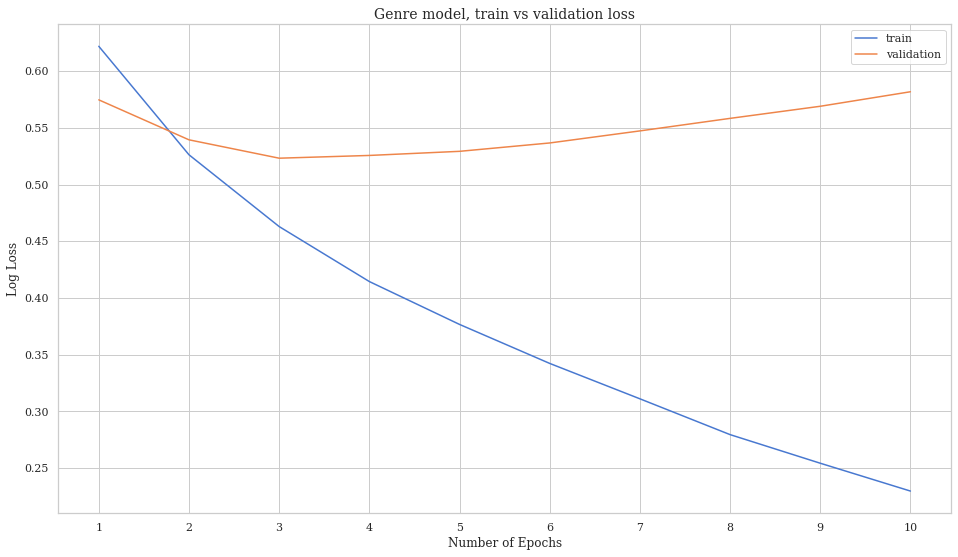

In [25]:
# plot training curve of best model
plt.plot(np.arange(1,11,1), training.history['loss'], label='train')
plt.plot(np.arange(1,11,1), training.history['val_loss'], label='validation')
plt.xticks(np.arange(1,11,1))
plt.title('Genre model, train vs validation loss', fontsize=14)
plt.ylabel('Log Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.savefig('figures/5_ml1m-genre-epochs.pdf')
plt.show()

In [26]:
epoch_2 = np.argmin(training.history['val_loss'])+1
best_hparams = pd.concat((best_hparams, pd.Series({'epoch_2': epoch_2})))
best_hparams

n_factors      1000
n_hidden_2    [200]
epoch_1           4
epoch_2           3
dtype: object

In [27]:
del model1, model2

# compile both models
model1, model2 = compile_genre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_latent=best_hparams.n_factors,
    n_hidden_2=best_hparams.n_hidden_2
)

model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=bs1,
    epochs=best_hparams.epoch_1,
    verbose=1,
    validation_split=.2
)

# train genre model
training = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=bs2, 
    epochs=best_hparams.epoch_2,
    validation_split=.2)

Train on 800167 samples, validate on 200042 samples
Epoch 1/4
800167/800167 [==============================] - 59s 74us/sample - loss: 0.8893 - val_loss: 0.9348
Epoch 2/4
800167/800167 [==============================] - 58s 72us/sample - loss: 0.5997 - val_loss: 0.9373
Epoch 3/4
800167/800167 [==============================] - 58s 72us/sample - loss: 0.3126 - val_loss: 0.9401
Epoch 4/4
800167/800167 [==============================] - 58s 72us/sample - loss: 0.1270 - val_loss: 0.9423
Train on 2668 samples, validate on 667 samples
Epoch 1/3
2668/2668 [==============================] - 1s 369us/sample - loss: 0.6218 - accuracy: 0.6503 - AUC: 0.7152 - val_loss: 0.5746 - val_accuracy: 0.6882 - val_AUC: 0.7270
Epoch 2/3
2668/2668 [==============================] - 0s 147us/sample - loss: 0.5262 - accuracy: 0.7369 - AUC: 0.8209 - val_loss: 0.5394 - val_accuracy: 0.7076 - val_AUC: 0.7724
Epoch 3/3
2668/2668 [==============================] - 0s 147us/sample - loss: 0.4630 - accuracy: 0.7841 - 

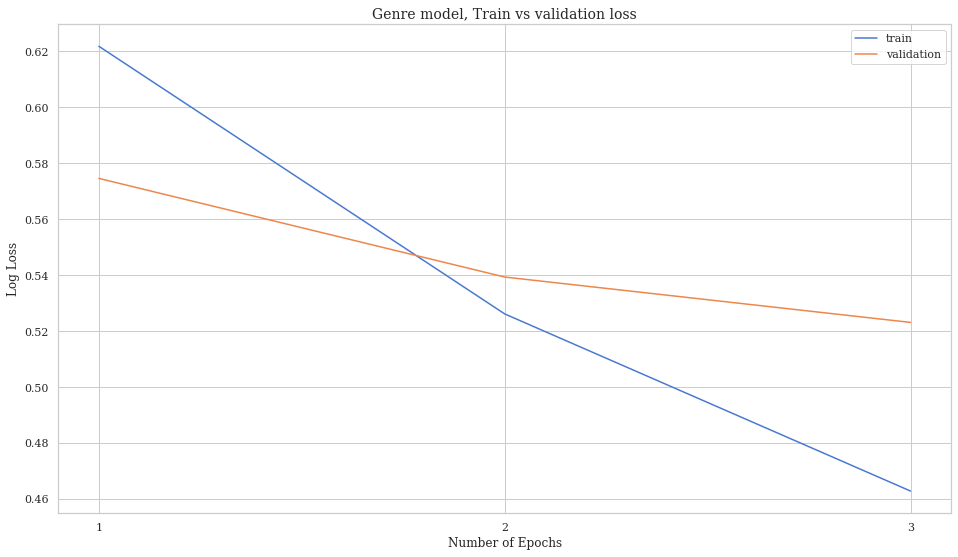

In [28]:
# plot training curve of best model
plt.plot(np.arange(1,epoch_2+1,1), training.history['loss'], label='train')
plt.plot(np.arange(1,epoch_2+1,1), training.history['val_loss'], label='validation')
plt.xticks(np.arange(1,epoch_2+1,1))
plt.title('Genre model, Train vs validation loss', fontsize=14)
plt.ylabel('Log Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show()

## 3. Dropout rates

In [29]:
# hyper parameters
HP_DROPOUT_2 = [0, .05, .1]

In [31]:
# dataframe to store results of grid search
grid_results_2 = []
searches = 1

n_models = len(HP_DROPOUT_2)

print(f'Fitting total of {n_models} models\n')

for DROPOUT_2 in HP_DROPOUT_2:

    print(f'Fitting CGT model #{searches} with dr2: {DROPOUT_2}')
    searches += 1

    # Create 5 CV folds
    kf = KFold(n_splits=5, random_state=42)

    # initialise loss and epoch count
    total_loss = 0
    total_acc = 0
    count = 1

    # do CV split and compute baseline predictors each time
    for train_index, test_index in kf.split(movies):

        # get baseline rating predictors for full dataset
        train, _, _ = get_baseline(df, df.index, df.index, 'userId', 'movieId')

        # compile both models with search hparams
        model1, model2 = compile_genre_model(
            n_items=df.movieId.nunique(),
            n_users=df.userId.nunique(),
            min_rating=df.rating.min(),
            max_rating=df.rating.max(),
            mean_rating=df.rating.mean(),
            n_latent=best_hparams.n_factors,
            n_hidden_2=best_hparams.n_hidden_2,
            dropout_2=DROPOUT_2
        )

        # train rating model on all data
        ratings = model1.fit(
            x=[train.userId.values, train.movieId.values, train.bias.values],
            y=train.rating.values, 
            batch_size=bs1,
            epochs=best_hparams.epoch_1,
            verbose=0,
            validation_split=.2
        )

        # train genre model on 5 CV folds
        train = movies.iloc[train_index]
        test = movies.iloc[test_index]

        # train model on current fold
        result = model2.fit(
            train.movieId.values, train.Drama.values,
            batch_size=bs2, 
            epochs=best_hparams.epoch_2,
            verbose=0,
            validation_data=(test.movieId.values, test.Drama.values))

        # get loss from this fold
        fold_loss = result.history['val_loss'][-1]
        total_loss += fold_loss
        fold_acc = result.history['val_accuracy'][-1]
        total_acc += fold_acc
        count += 1

        del model1, model2

    # calculate average holdout loss across all CV folds
    avg_loss = total_loss / 5
    avg_acc = total_acc / 5
    print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
    print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

    grid_results_2.append({'dropout_2':DROPOUT_2,
                           'val_loss':avg_loss,
                           'val_acc':avg_acc,
                           'train_loss_hist':result.history['loss'],
                           'val_loss_hist':result.history['val_loss'],
                           'train_acc_hist':result.history['accuracy'],
                           'val_acc_hist':result.history['val_accuracy']})

    print()
#             break
#         break
    
col_order = grid_results_2[0].keys()

# save results to data frame
grid_results_2 = pd.DataFrame(grid_results_2)
# reorder columns
grid_results_2 = grid_results_2[col_order]

Fitting total of 7 models

Fitting CGT model #1 with dr2: 0
_____________________________________CV avg val loss=0.5938
_____________________________________CV avg val acc=0.6669

Fitting CGT model #2 with dr2: 0.05
_____________________________________CV avg val loss=0.5941
_____________________________________CV avg val acc=0.6662

Fitting CGT model #3 with dr2: 0.1
_____________________________________CV avg val loss=0.5943
_____________________________________CV avg val acc=0.6662

Fitting CGT model #4 with dr2: 0.15
_____________________________________CV avg val loss=0.5946
_____________________________________CV avg val acc=0.6662

Fitting CGT model #5 with dr2: 0.2
_____________________________________CV avg val loss=0.5949
_____________________________________CV avg val acc=0.6669

Fitting CGT model #6 with dr2: 0.25
_____________________________________CV avg val loss=0.5952
_____________________________________CV avg val acc=0.6656

Fitting CGT model #7 with dr2: 0.3
_______

In [32]:
# get best 5 models
grid_results_2 = grid_results_2.sort_values('val_loss')
grid_results_2.to_csv(path+'grid_results_2.csv', index=False)

grid_results_2.head(5)

,dropout_2,val_loss,val_acc,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
0,0.00,0.593771,0.666903,"[0.6656087191512425, 0.5915942607489034, 0.536...","[0.6259539853658108, 0.5912225716161412, 0.581...","[0.6003303, 0.6961189, 0.7580512, 0.80099094]","[0.6655629, 0.66887414, 0.69205296, 0.6721854]"
1,0.05,0.594128,0.666243,"[0.6657016839890515, 0.592471919849232, 0.5385...","[0.6269177482617612, 0.5921741277966278, 0.581...","[0.5887696, 0.6961189, 0.7555739, 0.80759704]","[0.66887414, 0.6721854, 0.69205296, 0.66887414]"
2,0.10,0.594339,0.666240,"[0.6661896509242196, 0.5937153425322989, 0.541...","[0.6280238296811944, 0.5930081830908921, 0.581...","[0.5928984, 0.6952931, 0.7539224, 0.80264246]","[0.66887414, 0.6721854, 0.69205296, 0.6655629]"
3,0.15,0.594610,0.666240,"[0.6668613005727899, 0.5958881354548535, 0.544...","[0.6294288840514934, 0.5943749941737446, 0.582...","[0.5862923, 0.6919901, 0.748142, 0.8034682]","[0.6754967, 0.66887414, 0.68874174, 0.66225165]"
4,0.20,0.594909,0.666903,"[0.667606014736815, 0.597347192041742, 0.54840...","[0.6306698689397597, 0.595657706655414, 0.5829...","[0.5821635, 0.688687, 0.7431874, 0.7919075]","[0.6655629, 0.66887414, 0.70198673, 0.6655629]"


In [35]:
best_hparams = pd.concat((best_hparams, grid_results_2.iloc[0,:][['dropout_2']]))
best_hparams

n_factors      1000
n_hidden_2    [200]
epoch_1           4
epoch_2           4
dropout_2         0
dtype: object

# Classification report

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Re-train model on full dataset, with best hparams

In [44]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index, 'userId', 'movieId')

# compile both models
model1, model2 = compile_genre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_latent=best_hparams.n_factors,
    n_hidden_2=best_hparams.n_hidden_2,
    dropout_2=best_hparams.dropout_2
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=bs1,
    epochs=best_hparams.epoch_1,
    verbose=1,
    validation_split=.2
)

# train genre model
genres = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=bs2,
    epochs=best_hparams.epoch_2,
    validation_split=.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/4
80000/80000 [==============================] - 6s 73us/sample - loss: 0.9479 - val_loss: 0.9290
Epoch 2/4
80000/80000 [==============================] - 6s 75us/sample - loss: 0.7535 - val_loss: 0.8814
Epoch 3/4
80000/80000 [==============================] - 7s 84us/sample - loss: 0.4572 - val_loss: 0.8368
Epoch 4/4
80000/80000 [==============================] - 7s 83us/sample - loss: 0.2048 - val_loss: 0.8340
Train on 1210 samples, validate on 303 samples
Epoch 1/4
1210/1210 [==============================] - 1s 708us/sample - loss: 0.6649 - accuracy: 0.5793 - AUC: 0.6414 - val_loss: 0.6208 - val_accuracy: 0.6634 - val_AUC: 0.7532
Epoch 2/4
1210/1210 [==============================] - 0s 173us/sample - loss: 0.5925 - accuracy: 0.6810 - AUC: 0.7891 - val_loss: 0.5913 - val_accuracy: 0.6733 - val_AUC: 0.7567
Epoch 3/4
1210/1210 [==============================] - 0s 180us/sample - loss: 0.5369 - accuracy: 0.7587 - AUC: 0.8482 - 

### Evaluate on test set

In [45]:
X_test = movies_holdout.movieId.values
y_test = movies_holdout.Drama.values
y_score = pd.DataFrame(model2.predict(X_test))
y_pred = y_score.round().astype('int')

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67        96
           1       0.57      0.60      0.59        73

    accuracy                           0.63       169
   macro avg       0.63      0.63      0.63       169
weighted avg       0.64      0.63      0.63       169



In [47]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,63,33
1,29,44


In [48]:
# add predictions as column
movies_holdout['prediction'] = y_pred.values
# save to csv
movies_holdout[['movieId', 'title', 'Drama', 'prediction']].to_csv(path+'holdout_predictions.csv', index=False)

In [49]:
X_train = movies.movieId.values
y_train = movies.Drama.values
train_score = pd.DataFrame(model2.predict(X_train))
train_pred = train_score.round().astype('int')

In [50]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       861
           1       0.81      0.74      0.77       652

    accuracy                           0.81      1513
   macro avg       0.81      0.80      0.81      1513
weighted avg       0.81      0.81      0.81      1513



In [51]:
pd.DataFrame(confusion_matrix(y_train, train_pred))

,0,1
0,745,116
1,168,484


In [52]:
# add predictions as column
movies['prediction'] = train_pred.values
# save to csv
movies[['movieId', 'title', 'Drama', 'prediction']].to_csv(path+'train_predictions.csv', index=False)

---
# Appendix A: multi-label genre model

In [55]:
from CGT import compile_multigenre_model

In [60]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index, 'userId', 'movieId')

# compile both models
model1, model2 = compile_multigenre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_genres=18,
    n_latent=best_hparams.n_factors, 
    n_hidden_2=best_hparams.n_hidden_2,
    dropout_2=best_hparams.dropout_2
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=bs1,
    epochs=best_hparams.epoch_1,
    verbose=1,
    validation_split=.2
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/4
80000/80000 [==============================] - 6s 74us/sample - loss: 0.9479 - val_loss: 0.9290
Epoch 2/4
80000/80000 [==============================] - 5s 68us/sample - loss: 0.7535 - val_loss: 0.8814
Epoch 3/4
80000/80000 [==============================] - 7s 94us/sample - loss: 0.4572 - val_loss: 0.8368
Epoch 4/4
80000/80000 [==============================] - 8s 101us/sample - loss: 0.2048 - val_loss: 0.8340


In [61]:
# train genre model
genres = model2.fit(
    movies.movieId.values, movies.iloc[:,-19:-1].values,  # multi label
    batch_size=bs2, 
    epochs=best_hparams.epoch_2,
    validation_split=.2)

Train on 1210 samples, validate on 303 samples
Epoch 1/4
1210/1210 [==============================] - 1s 638us/sample - loss: 0.6501 - accuracy: 0.7549 - AUC: 0.5697 - val_loss: 0.5856 - val_accuracy: 0.8907 - val_AUC: 0.6270
Epoch 2/4
1210/1210 [==============================] - 0s 183us/sample - loss: 0.5038 - accuracy: 0.9072 - AUC: 0.6634 - val_loss: 0.4366 - val_accuracy: 0.9041 - val_AUC: 0.6216
Epoch 3/4
1210/1210 [==============================] - 0s 184us/sample - loss: 0.3727 - accuracy: 0.9093 - AUC: 0.6815 - val_loss: 0.3580 - val_accuracy: 0.9076 - val_AUC: 0.6602
Epoch 4/4
1210/1210 [==============================] - 0s 181us/sample - loss: 0.3110 - accuracy: 0.9119 - AUC: 0.7305 - val_loss: 0.3233 - val_accuracy: 0.9098 - val_AUC: 0.6998


In [62]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [63]:
y_true = movies.iloc[:,-19:-1]
y_score = pd.DataFrame(model2.predict(movies.movieId.values), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [64]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

              precision    recall  f1-score   support

      Action       0.76      0.08      0.15       232
   Adventure       0.00      0.00      0.00       127
   Animation       0.00      0.00      0.00        37
  Children's       0.00      0.00      0.00       111
      Comedy       0.72      0.17      0.27       452
       Crime       0.00      0.00      0.00        96
 Documentary       0.00      0.00      0.00        44
       Drama       0.64      0.63      0.63       652
     Fantasy       0.00      0.00      0.00        20
   Film-Noir       0.00      0.00      0.00        22
      Horror       0.00      0.00      0.00        85
     Musical       0.00      0.00      0.00        47
     Mystery       0.00      0.00      0.00        56
     Romance       0.00      0.00      0.00       221
      Sci-Fi       1.00      0.01      0.02        91
    Thriller       1.00      0.00      0.01       225
         War       0.00      0.00      0.00        60
     Western       0.00    

C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
